In [52]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import paddleocr
import time
import os


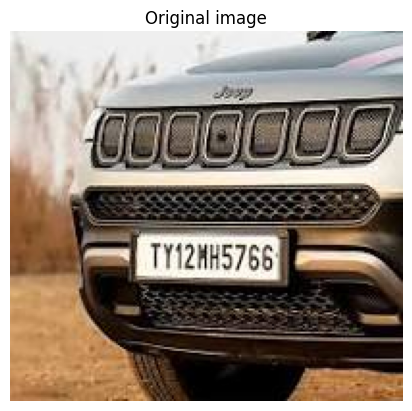

In [2]:
image_path=r'/Users/lalitha/VehicleDetection/data/numberplate.jpeg'
img=cv2.imread(image_path)
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Original image')
plt.show()


In [6]:
model = YOLO(r'/Users/lalitha/VehicleDetection/model/best.onnx')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [12]:
results = model(img_rgb)
print(results)


0: 640x640 1 license_plate, 53.9ms
Speed: 4.4ms preprocess, 53.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[240, 240, 238],
        [234, 234, 232],
        [228, 228, 226],
        ...,
        [133, 147, 150],
        [132, 146, 149],
        [131, 145, 148]],

       [[241, 241, 239],
        [235, 235, 233],
        [229, 229, 227],
        ...,
        [171, 185, 188],
        [175, 186, 190],
        [176, 190, 193]],

       [[244, 244, 242],
        [238, 238, 236],
        [230, 230, 228],
        ...,
        [189, 200, 204],
        [192, 201, 206],
        [192, 203, 207]],

       ...,

       [[182, 124,  76],
        [176, 118,  70],
        [174, 116,  68],
        ...,
        [159,  98,  44],
        [154,  93,  39],
        [150,  89,  35]],

       [[1

In [14]:
# If results is a list, loop over each detection result
for result in results:
    boxes = result.boxes  # Access boxes for each result
    print(boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.80080])
data: tensor([[ 64.35148, 102.69770, 143.88040, 130.29672,   0.80080,   0.00000]])
id: None
is_track: False
orig_shape: (192, 204)
shape: torch.Size([1, 6])
xywh: tensor([[104.11594, 116.49721,  79.52892,  27.59902]])
xywhn: tensor([[0.51037, 0.60676, 0.38985, 0.14374]])
xyxy: tensor([[ 64.35148, 102.69770, 143.88040, 130.29672]])
xyxyn: tensor([[0.31545, 0.53488, 0.70530, 0.67863]])


In [31]:
# Check if any boxes were detected
print(f"Number of detected boxes: {len(results[0].boxes)}")
if len(results[0].boxes) == 0:
    print("No license plates detected.")


Number of detected boxes: 1


In [32]:
# Extract bounding box coordinates (xywh format), confidence, and class ids
xywh = results[0].boxes.xywh  # [x_center, y_center, width, height]
conf = results[0].boxes.conf  # Confidence scores
cls = results[0].boxes.cls    # Class IDs (for license plates)

# Since we have only one box, we'll print the details of the first box
x_center, y_center, width, height = xywh[0]
print(f"Bounding box coordinates (center_x, center_y, width, height): {x_center}, {y_center}, {width}, {height}")

# Convert to x1, y1, x2, y2 for cropping (Top-left, Bottom-right corners)
x1 = int(x_center - width / 2)
y1 = int(y_center - height / 2)
x2 = int(x_center + width / 2)
y2 = int(y_center + height / 2)

print(f"Cropping coordinates: ({x1}, {y1}), ({x2}, {y2})")

Bounding box coordinates (center_x, center_y, width, height): 104.11593627929688, 116.49720764160156, 79.52892303466797, 27.599021911621094
Cropping coordinates: (64, 102), (143, 130)


In [33]:
img_height, img_width, _ = img_rgb.shape
print(f"Image dimensions: {img_width}x{img_height}")


Image dimensions: 204x192


In [35]:
# Ensure the coordinates are within the bounds of the image
img_height, img_width, _ = img_rgb.shape
if x1 < 0: x1 = 0
if y1 < 0: y1 = 0
if x2 > img_width: x2 = img_width
if y2 > img_height: y2 = img_height

print(f"Adjusted coordinates: ({x1}, {y1}), ({x2}, {y2})")

# Crop the license plate using the adjusted bounding box
cropped_plate = img_rgb[y1:y2, x1:x2]

# Check if the cropped image has valid dimensions
print(f"Cropped image dimensions: {cropped_plate.shape}")

# If cropped_plate has non-zero size, display it
if cropped_plate.shape[0] > 0 and cropped_plate.shape[1] > 0:
    plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
    plt.title("Cropped License Plate")
    plt.axis('off')
    plt.show()
else:
    print("Cropped image is empty!")

Adjusted coordinates: (64, 102), (143, 130)
Cropped image dimensions: (28, 79, 3)


In [37]:
plt.imshow(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))
plt.title("Cropped License Plate")
plt.axis('off')
plt.show()

In [38]:
cv2.imwrite('cropped_license_plate.jpg', cropped_plate)

True

In [43]:
ocr = paddleocr.PaddleOCR(use_angle_cls=True, lang='en')

[2025/05/14 13:25:27] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/lalitha/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/lalitha/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch

In [44]:
result = ocr.ocr(cropped_plate, cls=True)


[2025/05/14 13:25:46] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.024422168731689453
[2025/05/14 13:25:46] ppocr DEBUG: cls num  : 1, elapsed : 0.015115976333618164
[2025/05/14 13:25:46] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05262589454650879


In [45]:
for line in result[0]:
    print(f"Detected text: {line[1]}")

Detected text: ('TY12MH5766', 0.9345235824584961)


In [47]:
unauthorized_plates = {
    "TS09AB1234": "Blacklisted",
    "AP11CD9999": "Expired Pass",
    "MH14XY4567": "Stolen Vehicle"
}

In [48]:
recent_alerts = {}
ALERT_INTERVAL = 30  # seconds

In [49]:
def check_alert(plate_number):
    now = time.time()
    if plate_number in recent_alerts and now - recent_alerts[plate_number] < ALERT_INTERVAL:
        return False
    recent_alerts[plate_number] = now
    return True

In [51]:
def trigger_alert(plate_number, reason):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[ALERT] {timestamp} - {plate_number} - {reason}")